In [1]:
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import torch
import imgviz
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def save_colored_mask(save_path, mask_pil):
    """保存调色板彩色图"""
    lbl_pil = mask_pil.convert('P')
    # lbl_pil = Image.fromarray(mask.astype(np.uint8), mode='P')
    colormap = imgviz.label_colormap(80)
    # colormap[0] = [169, 169, 169]  # 灰色的RGB值
    colormap[0] = [0, 0, 0]  # 灰色的RGB值
    lbl_pil.putpalette(colormap.flatten())
    lbl_pil.save(save_path)

def save_bbox_img(colored_res_path, bboxes, size=512, name="bbox.png"):
    scale_fct = torch.tensor([size, size, size, size]).to(device)
    bboxes = bboxes * scale_fct
    out_image = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(out_image)
    for n, b in enumerate(bboxes):
        draw.rectangle(((b[0], b[1]), (b[2], b[3])),
                       fill=None, outline=n+1, width=5)
    save_colored_mask(os.path.join(colored_res_path, name), out_image)
    plt.imshow(out_image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    return out_image

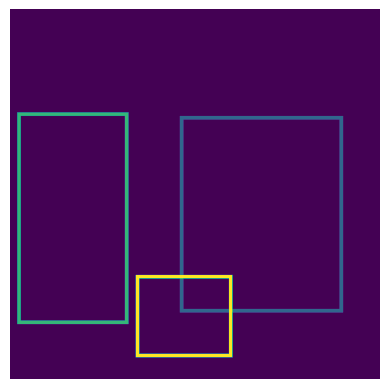

In [9]:
layout = [[0.46, 0.29, 0.90, 0.82], [0.02, 0.28, 0.32, 0.85], [0.34, 0.72, 0.60, 0.94]] # [x1, y1, x2, y2]
bboxes = torch.tensor(layout).to(device)
out_image = save_bbox_img("results", bboxes, size=512, name="bbox.png")

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import argparse
import torch
from boxnet_models import build_model, add_boxnet_args
from utils.utils import save_colored_mask, save_bbox_img, save_img_with_box
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
boxnet_path = "./ckpt/boxnet.pth"
parser = argparse.ArgumentParser()
parser = add_boxnet_args(parser)
args = parser.parse_args()
if boxnet_path is not None:
    args.no_class = True
    boxnet, _, _ = build_model(args)
    boxnet.load_state_dict(torch.load(boxnet_path))
    boxnet = boxnet.to(device)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, EulerDiscreteScheduler
from torchvision.utils import save_image, make_grid
model_id = "/data/zsz/ssh/models/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9/"
# model_id = "runwayml/stable-diffusion-v1-5"
# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
# pipe = StableDiffusionPipeline.from_pretrained(model_id, cache_dir="/data/zsz/models/storage_file/models/",resume_download=True)
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seed = int(torch.rand((1,)) * 100000)
generator = torch.Generator(device).manual_seed(seed)
def save_image_cuda(x, path, nrow=1, normalize=True, value_range=(-1., 1.)):
    img = make_grid(x, nrow=nrow, normalize=normalize)
    save_image(img, path)

/data/conda/envs/ICML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.20it/s]


In [ ]:
prompt = "A solitary lighthouse perched on rugged cliffs illuminates the waves below. The horizon is painted in hues of pink and gold."
image = pipe(prompt).images[0]
image.save("astronaut_rides_horse.png")
print("finish")

In [12]:
import numpy as np
from diffusers.utils import PIL_INTERPOLATION
from PIL import Image

def preprocess_image(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL_INTERPOLATION["lanczos"])
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0
init_latents = Image.open('./4.jpg').convert('RGB')
init_latents = preprocess_image(init_latents)
shape = init_latents.shape
init_latents = init_latents.to(device)
noise = torch.randn(shape, generator=generator, device=device) # if len(noise_preds) == 0 else noise_preds[time]
pipe.scheduler.set_timesteps(1000)
timesteps = pipe.scheduler.timesteps.to(device)
time = 960
t = timesteps[time - 1] * torch.ones(init_latents.shape[0]).to(device)
t = t.long()
latents = pipe.scheduler.add_noise(init_latents, noise, t)
save_image_cuda(latents, "latents.png")

In [ ]:
import importlib
def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

In [ ]:
from lavis.models import load_model_and_preprocess
import torch
from PIL import Image
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load sample image
raw_image = Image.open("./1.jpg").convert("RGB")
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", model_type="base", is_eval=True, device=device)
caption = "an elephat is left to a cat"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
text_input = txt_processors["eval"](caption)
sample = {"image": image, "text_input": [text_input]}

features_multimodal = model.extract_features(sample)
print(features_multimodal.multimodal_embeds.shape)
# torch.Size([1, 12, 768]), use features_multimodal[:,0,:] for multimodal classification tasks

features_image = model.extract_features(sample, mode="image")
features_text = model.extract_features(sample, mode="text")
print(features_image.image_embeds.shape)
# torch.Size([1, 197, 768])
print(features_text.text_embeds.shape)
# torch.Size([1, 12, 768])

# low-dimensional projected features
print(features_image.image_embeds_proj.shape)
# torch.Size([1, 197, 256])
print(features_text.text_embeds_proj.shape)
# torch.Size([1, 12, 256])
similarity = features_image.image_embeds_proj[:,0,:] @ features_text.text_embeds_proj[:,0,:].t()
print(similarity)
# tensor([[0.2622]])

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import torch
from lavis.models import load_model_and_preprocess
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
raw_image = Image.open("./4.jpg").convert("RGB")
# loads BLIP caption base model, with finetuned checkpoints on MSCOCO captioning dataset.
# this also loads the associated image processors
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

['a white plate topped with a cut in half sandwich next to a bowl of soup']